In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from wordcloud import WordCloud
import warnings

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

In [3]:
start_time = time.time()
complaints_cfpb = pd. DataFrame()

for chunk in pd.read_csv('complaints.csv', chunksize=400000):
    print('Number of chunks read: ', chunk.shape)
    complaints_cfpb = pd.concat([complaints_cfpb, chunk])

print("Time taken to read the data: ", time.time() - start_time)

print("Shape of the dataframe: ", complaints_cfpb.shape)

Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (335939, 18)
Time taken to read the data:  44.4320125579834
Shape of the dataframe:  (6335939, 18)


In [4]:
print(complaints_cfpb.head())

  Date received                                            Product  \
0    2024-07-27                                        Credit card   
1    2024-09-18  Credit reporting or other personal consumer re...   
2    2024-09-19                                       Student loan   
3    2024-06-09  Credit reporting or other personal consumer re...   
4    2024-07-24  Credit reporting or other personal consumer re...   

                                  Sub-product  \
0  General-purpose credit card or charge card   
1              Other personal consumer report   
2                        Private student loan   
3                            Credit reporting   
4                            Credit reporting   

                                  Issue  \
0                 Getting a credit card   
1  Incorrect information on your report   
2         Struggling to repay your loan   
3  Incorrect information on your report   
4  Incorrect information on your report   

                         

In [5]:
print(complaints_cfpb.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335939 entries, 0 to 6335938
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 9.0 

In [6]:
complaints_cfpb['Date received'] = pd.to_datetime(complaints_cfpb['Date received'], errors='coerce')
complaints_cfpb['Date sent to company'] = pd.to_datetime(complaints_cfpb['Date sent to company'], errors='coerce')

In [7]:
for col in complaints_cfpb.select_dtypes(include='object').columns:
    complaints_cfpb[col] = complaints_cfpb[col].astype('category')

In [8]:
def check_col_null_distribution(df):
    total_rows = df.shape[0]
    columns_with_null = df.columns[df.isnull().any()]
    
    null_percentages = {}
    
    for col in columns_with_null:
        null_count = df[col].isnull().sum()
        null_percentage = (null_count / total_rows) * 100
        null_percentages[col] = null_percentage
    
    return null_percentages 

In [9]:
def plot_null_percentage(df):
    null_percentages = check_col_null_distribution(df)
    
    columns_with_null = list(null_percentages.keys())
    percentages = list(null_percentages.values())

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=columns_with_null, y=percentages, palette='viridis')

    plt.xticks(rotation=90)

    for i, p in enumerate(ax.patches):
        ax.annotate(f'{percentages[i]:.2f}%', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Percentage of missing values')
    plt.xlabel('Columns')
    plt.title('Percentage of missing values in each column')
    plt.show()

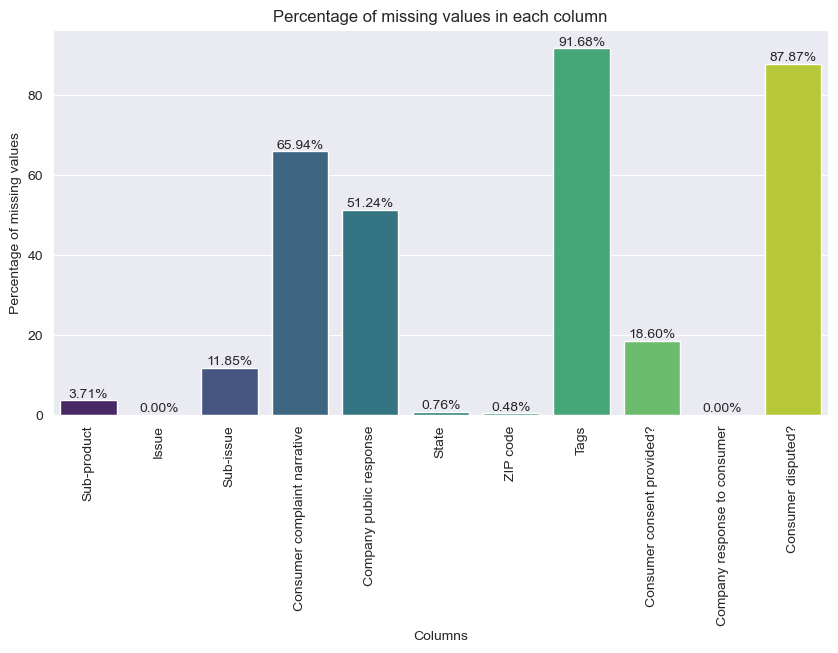

In [10]:
plot_null_percentage(complaints_cfpb)

In [11]:
complaints_cfpb = complaints_cfpb[complaints_cfpb['Date received'] >= '2023-01-01']

In [12]:
print("Minimum date in the dataset: ", complaints_cfpb['Date received'].min())
print("Maximum date in the dataset: ", complaints_cfpb['Date received'].max())

Minimum date in the dataset:  2023-01-01 00:00:00
Maximum date in the dataset:  2024-10-06 00:00:00


In [13]:
columns_to_retain = ['Product', 'Issue', 'Company response to consumer', 'Sub-product', 'Sub-issue', 'State', 'ZIP code']
columns_to_drop = ['Tags', 'Consumer disputed?', 'Consumer consent provided?', 'Consumer complaint narrative']

In [14]:
complaints_cfpb.drop(columns=columns_to_drop, axis=1, inplace=True)

In [15]:
complaints_cfpb['Sub-product'] = complaints_cfpb['Sub-product'].cat.add_categories("None").fillna("None")
complaints_cfpb['Sub-issue'] = complaints_cfpb['Sub-issue'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company response to consumer'] = complaints_cfpb['Company response to consumer'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company public response'] = complaints_cfpb['Company public response'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['State'] = complaints_cfpb['State'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['ZIP code'] = complaints_cfpb['ZIP code'].cat.add_categories("Not Provided").fillna("Not Provided")

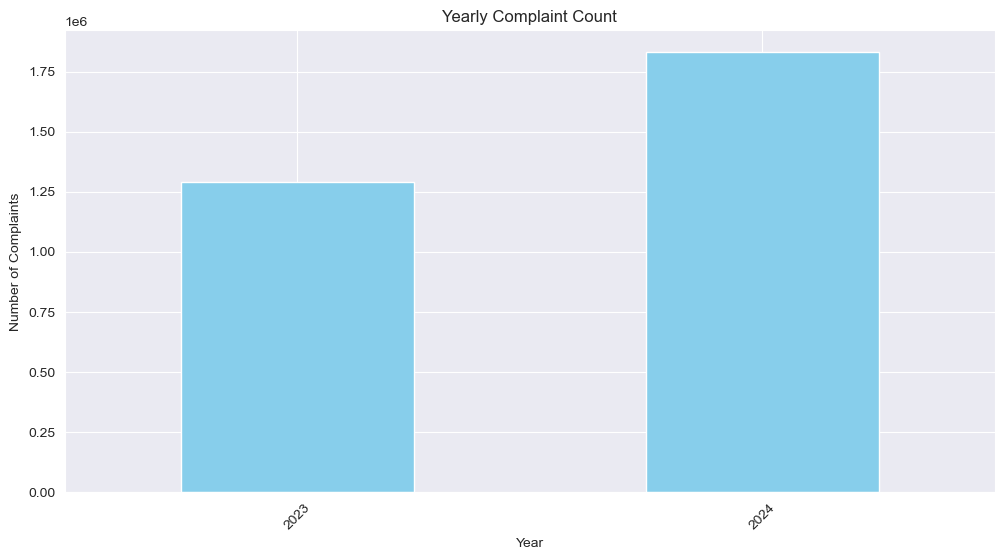

In [16]:
# Yearly Complaint Count
plt.figure(figsize=(12, 6))
complaints_cfpb['Date received'].dt.to_period('Y').value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Yearly Complaint Count")
plt.xlabel("Year")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.show()

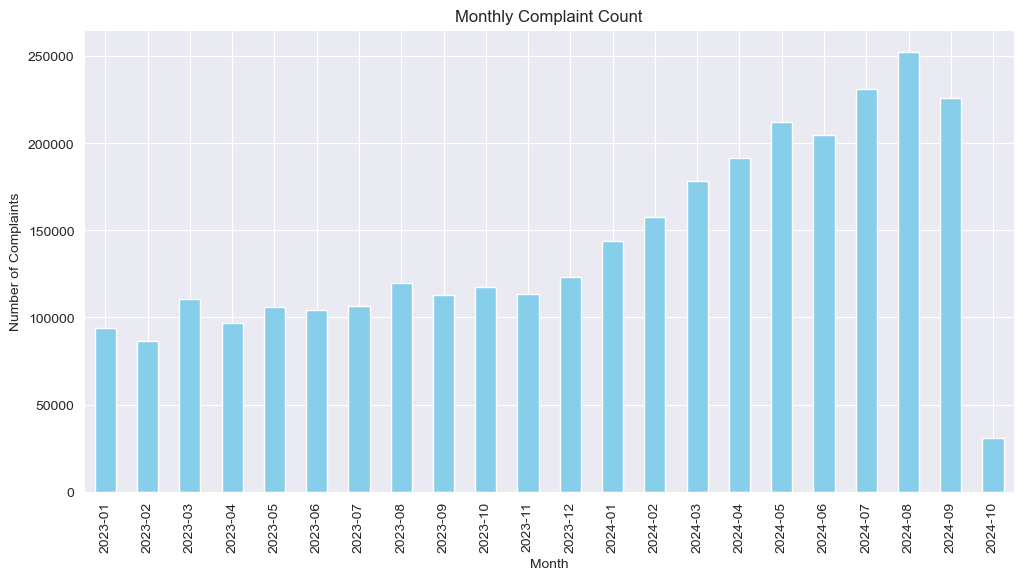

In [17]:
plt.figure(figsize=(12, 6))
complaints_cfpb['Date received'].dt.to_period('M').value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Monthly Complaint Count")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=90)
plt.show()

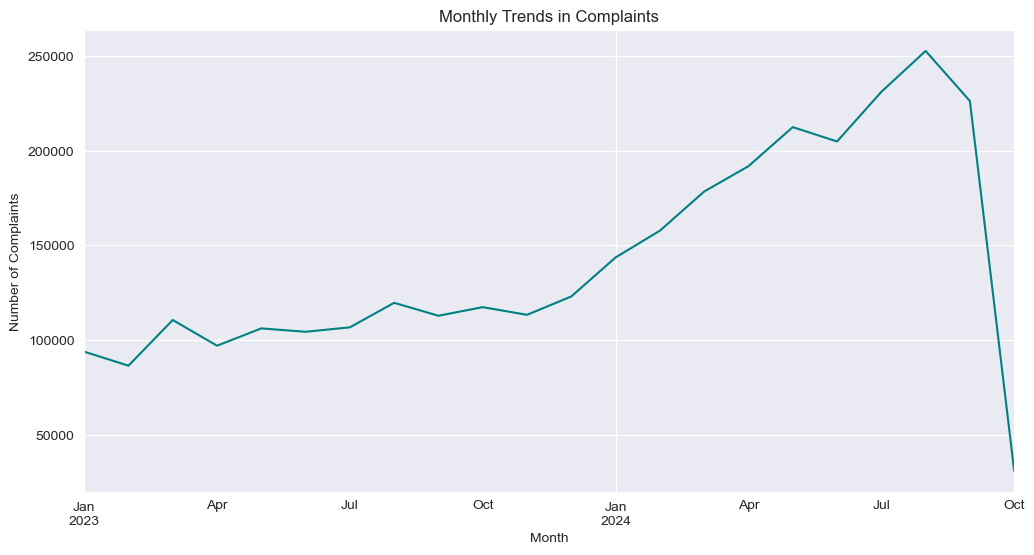

In [18]:
monthly_trends = complaints_cfpb.groupby(complaints_cfpb['Date received'].dt.to_period('M')).size()
monthly_trends.plot(kind='line', figsize=(12, 6), color='teal')
plt.title("Monthly Trends in Complaints")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.show()

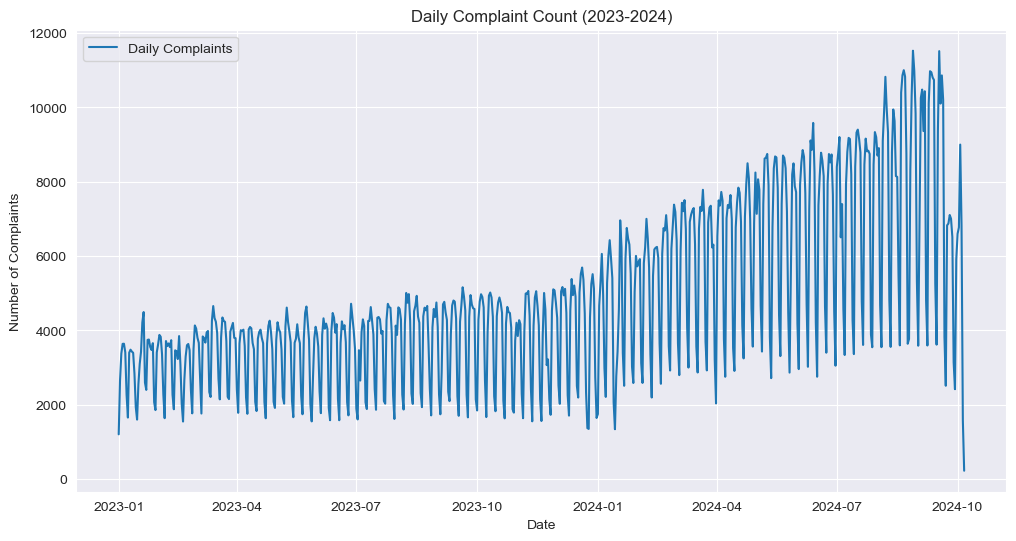

In [19]:
date_range = pd.date_range(start='2023-01-01', end='2024-10-06')
missing_dates = date_range.difference(complaints_cfpb['Date received'])

time_series = complaints_cfpb.groupby('Date received').size()
time_series = time_series.reindex(pd.date_range(start='2023-01-01', end='2024-10-06'), fill_value=0)
time_series.index.name = 'Date'
time_series = time_series.rename('Complaint Count')

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Daily Complaints')
plt.title('Daily Complaint Count (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()

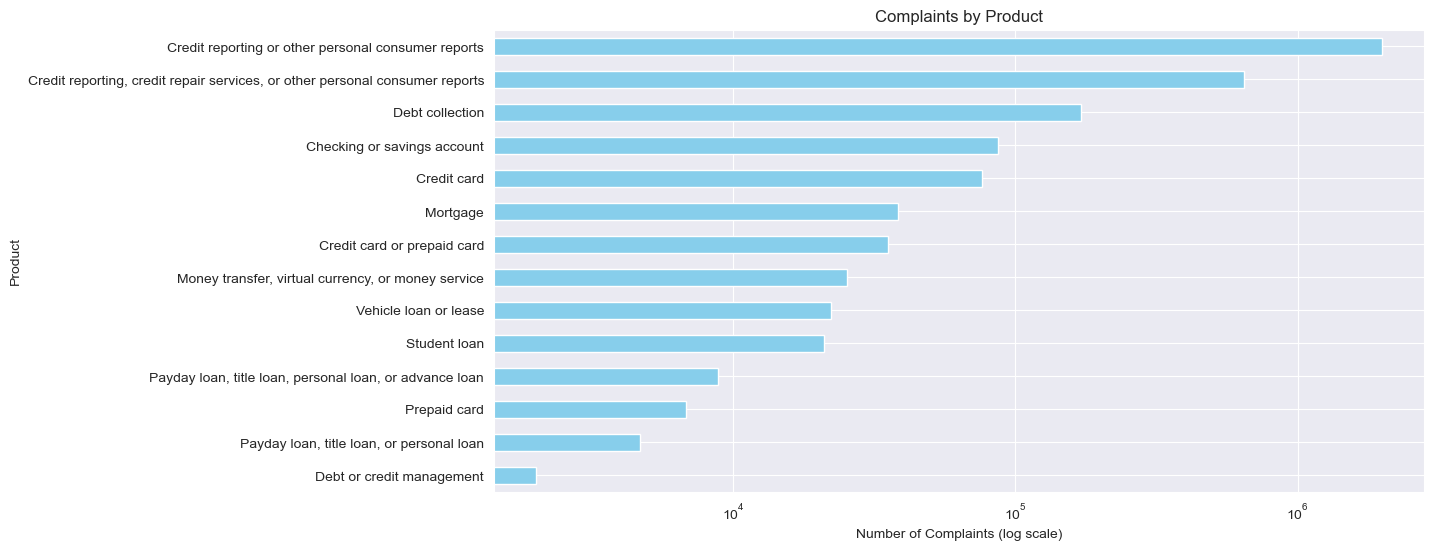

In [20]:
product_counts = complaints_cfpb['Product'].value_counts()
product_counts = product_counts[product_counts > 0]
product_counts = product_counts.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
product_counts.plot(kind='barh', color='skyblue', logx=True)
plt.xscale('log')
plt.title("Complaints by Product")
plt.xlabel("Number of Complaints (log scale)")
plt.ylabel("Product")
plt.show()


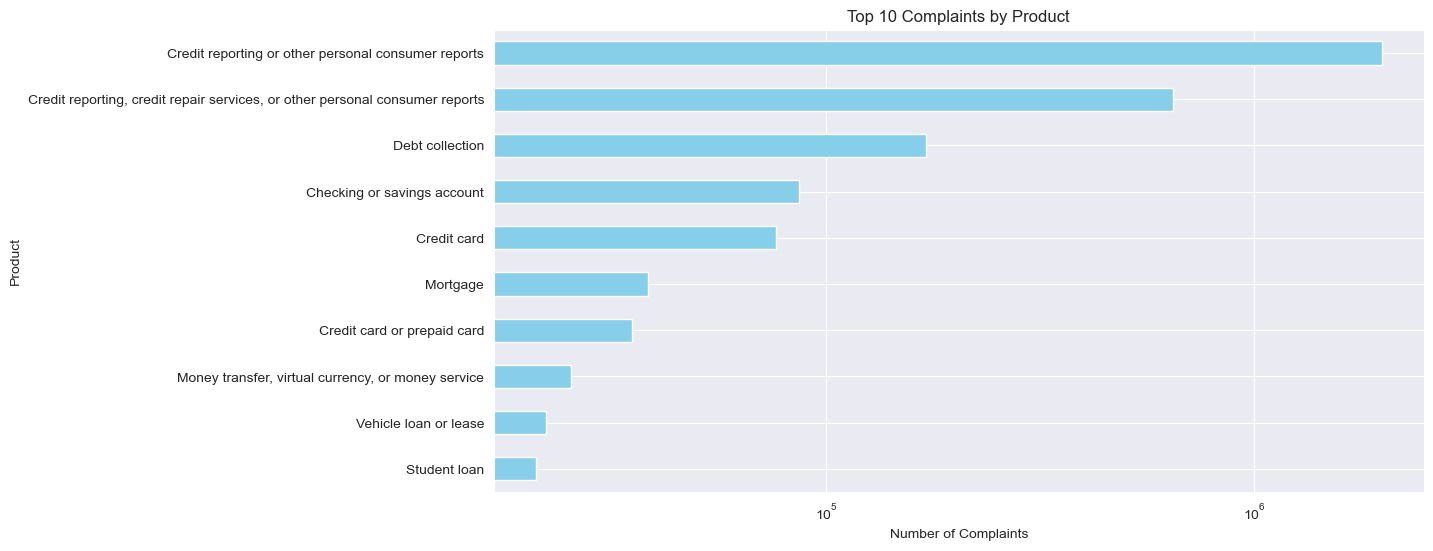

In [21]:
top_10_products = product_counts.tail(10)

plt.figure(figsize=(12, 6))
top_10_products.plot(kind='barh', color='skyblue', logx=True)
plt.title("Top 10 Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.show()


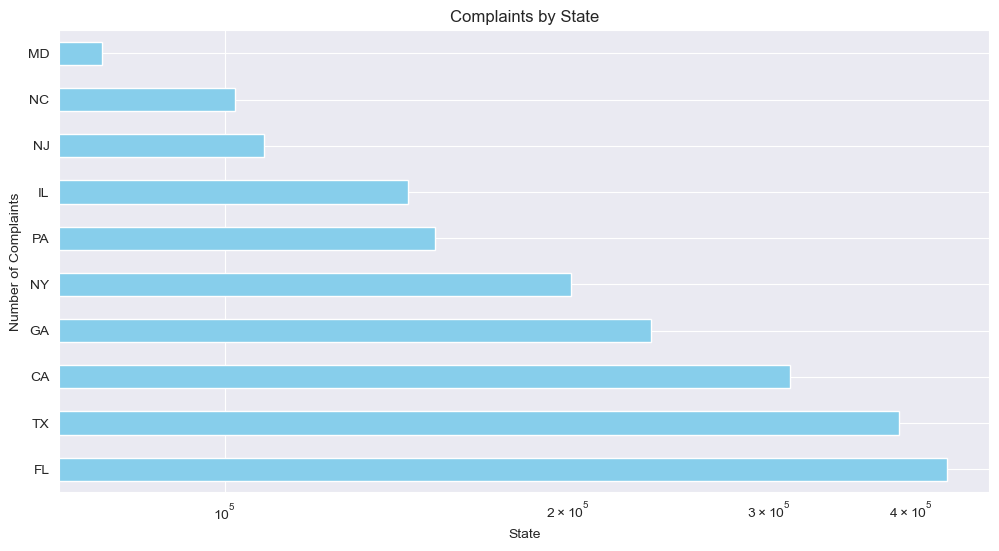

In [22]:
state_counts = complaints_cfpb['State'].value_counts().head(10)

plt.figure(figsize=(12, 6))
state_counts.plot(kind='barh', color='skyblue', logx=True)
plt.title("Complaints by State")
plt.xlabel("State")
plt.ylabel("Number of Complaints")
plt.show()

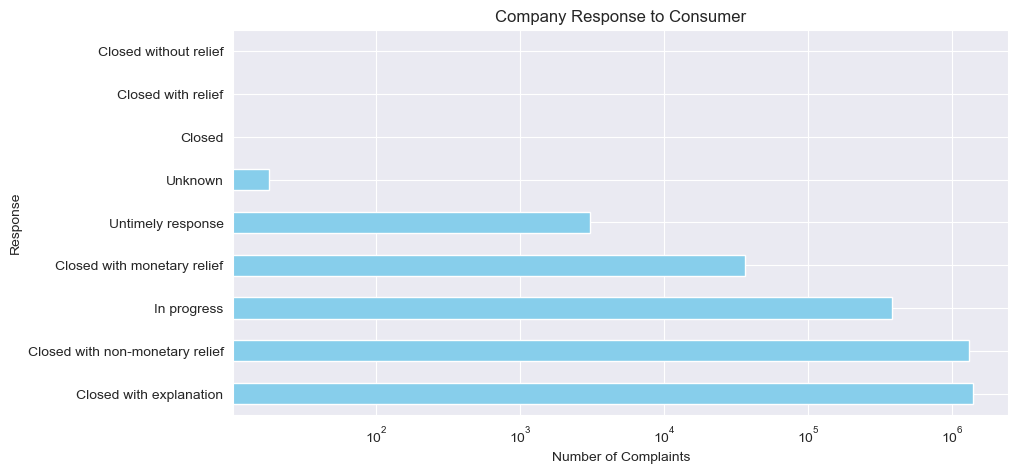

In [23]:
response_counts = complaints_cfpb['Company response to consumer'].value_counts()

plt.figure(figsize=(10, 5))
response_counts.plot(kind='barh', color='skyblue', logx=True)
plt.title("Company Response to Consumer")
plt.xlabel("Number of Complaints")
plt.ylabel("Response")
plt.show()

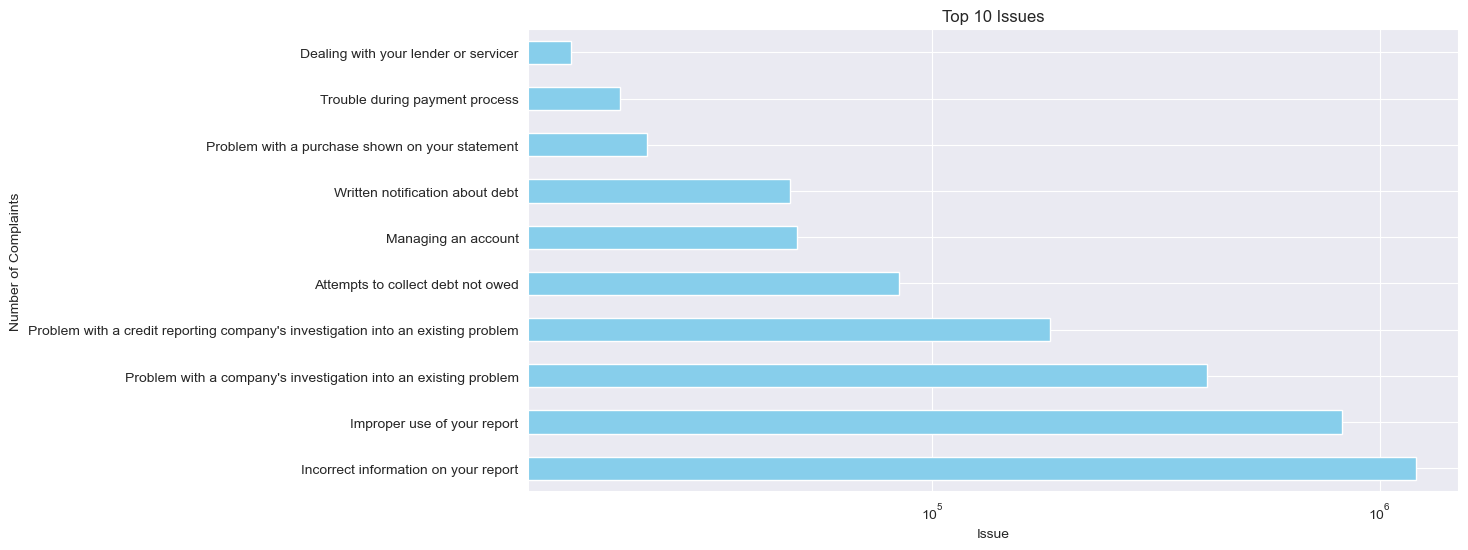

In [24]:
issue_counts = complaints_cfpb['Issue'].value_counts().head(10)

plt.figure(figsize=(12, 6))
issue_counts.plot(kind='barh', color='skyblue', logx=True)
plt.title("Top 10 Issues")
plt.xlabel("Issue")
plt.ylabel("Number of Complaints")
plt.show()


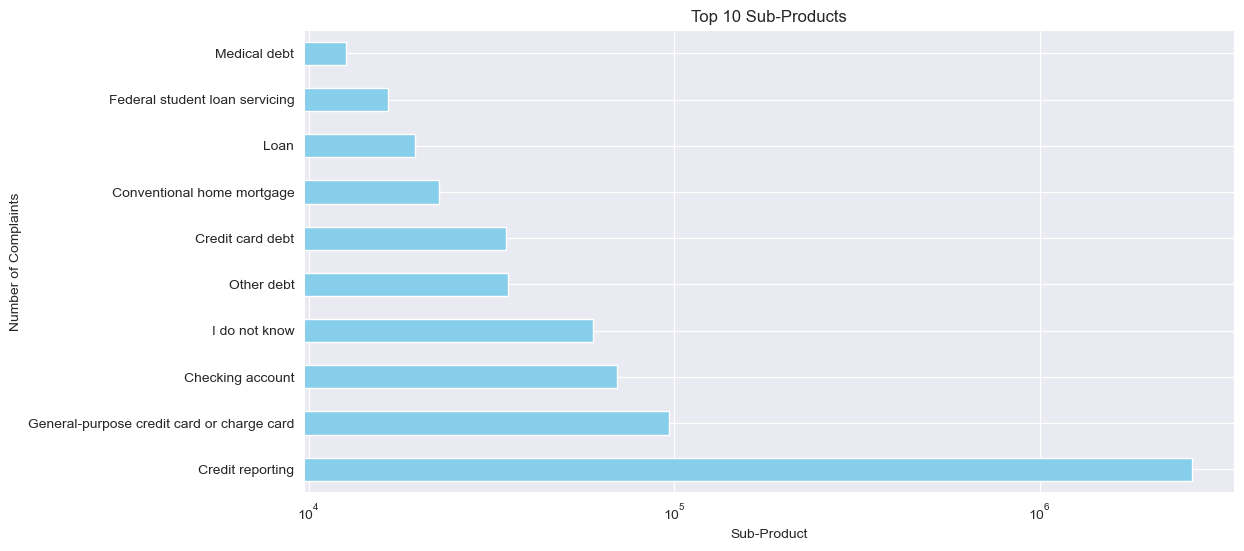

In [25]:
sub_product_counts = complaints_cfpb['Sub-product'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sub_product_counts.plot(kind='barh', color='skyblue', logx=True)
plt.title("Top 10 Sub-Products")
plt.xlabel("Sub-Product")
plt.ylabel("Number of Complaints")
plt.show()



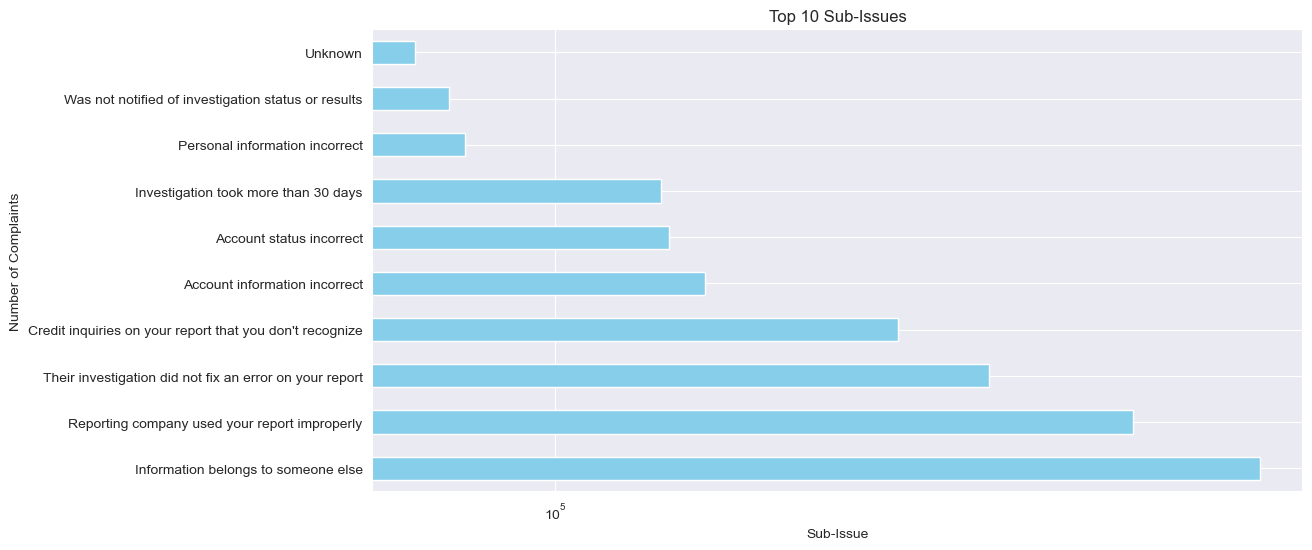

In [26]:
sub_issue_counts = complaints_cfpb['Sub-issue'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sub_issue_counts.plot(kind='barh', color='skyblue', logx=True)
plt.title("Top 10 Sub-Issues")
plt.xlabel("Sub-Issue")
plt.ylabel("Number of Complaints")
plt.show()

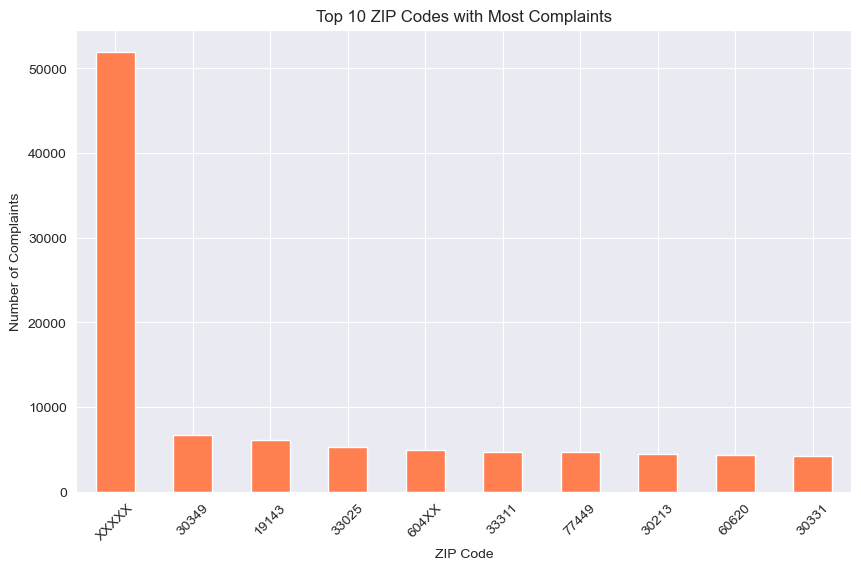

In [27]:
plt.figure(figsize=(10, 6))
complaints_cfpb['ZIP code'].value_counts().head(10).plot(kind='bar', color='coral')
plt.title("Top 10 ZIP Codes with Most Complaints")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.show()

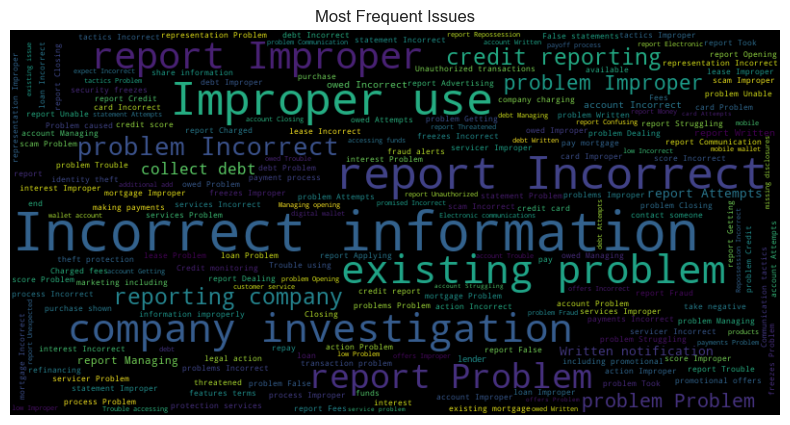

In [28]:
text_data = ' '.join(complaints_cfpb['Issue'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Issues")
plt.show()

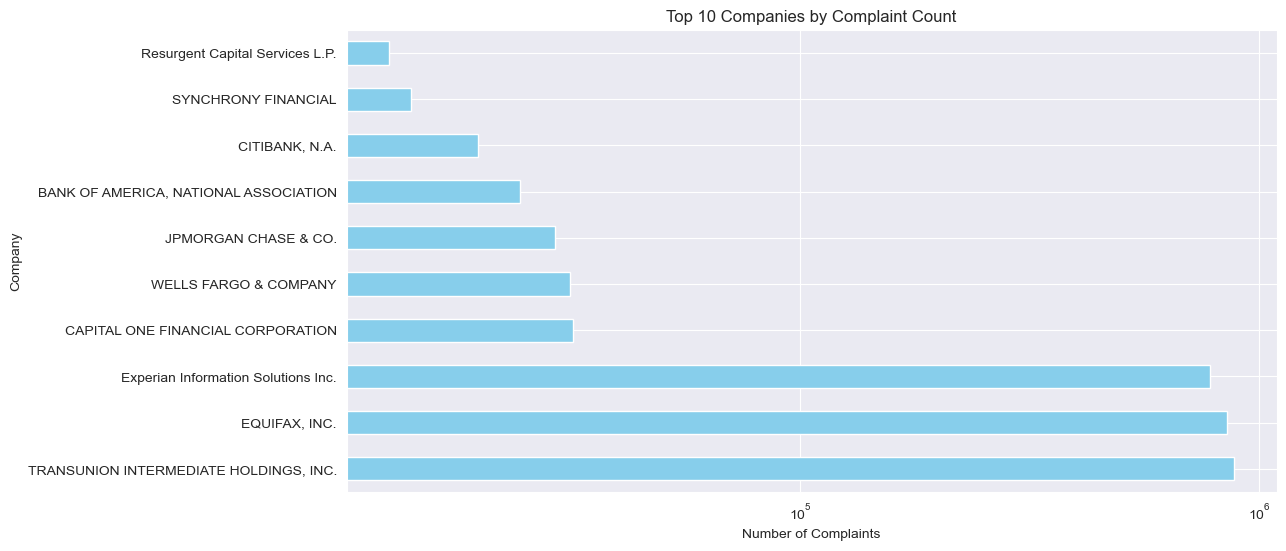

In [29]:
top_companies = complaints_cfpb['Company'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_companies.plot(kind='barh', color='skyblue', logx=True)
plt.title("Top 10 Companies by Complaint Count")
plt.xlabel("Number of Complaints")
plt.ylabel("Company")
plt.show()